In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#!pip install netCDF4
from netCDF4 import Dataset as NetCDFFile
import random
import timeit
import pickle
from scipy import stats
import xarray as xr
import pandas as pd
import statistics
from scipy import interpolate
import os
import pytz, datetime
import multiprocessing as mp
import geopandas
#!pip install descartes
import descartes
from datetime import date

from datetime import datetime

import json
import openai
import os 

def load_api_key(secrets_file="/Users/kaichiht/openai.json"):
    with open(secrets_file) as f:
        secrets = json.load(f)
    return secrets["OPENAI_API_KEY"]

# Set secret API key
# Typically, we'd use an environment variable (e.g., echo "export OPENAI_API_KEY='yourkey'" >> ~/.zshrc)
# However, using "internalConsole" in launch.json requires setting it in the code for compatibility with Hebrew
api_key = load_api_key()
openai.api_key = api_key

%reload_ext jupyter_ai

os.environ["OPENAI_API_KEY"]=openai.api_key

In [49]:
%%ai chatgpt

calculate mean of specific dimension but keep the total dimension of the array in python

To calculate the mean of a specific dimension while keeping the total dimension of the array in Python, you can use the `numpy` library.

Here is an example code snippet to calculate the mean of the second dimension of a 2D array while keeping the total dimension intact:

```python
import numpy as np

# Create a 2D array
arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Calculate the mean of the second dimension (axis=1)
mean = np.mean(arr, axis=1, keepdims=True)

print(mean)
```

Output:
```
[[2.]
 [5.]
 [8.]]
```

In this example, the mean of each row (second dimension) of the 2D array `arr` is calculated while keeping the total dimension intact.

## calculate daily climatology

In [4]:
import netCDF4 as nc

# Open the nc file
# nc_file = nc.Dataset('/Volumes/Expansion3/DATA/Reforecast/ECMWF/z/z_200511_ens01.nc', 'r')

# print((nc_file['gh'][0]).shape)
# # Access the variables in the nc file
# for var in nc_file.variables:
#     print(f'Variable: {var}')
#     print(f'Dimensions: {nc_file[var].dimensions}')
#     print(f'Attributes: {nc_file[var].ncattrs()}')
#     #print(f'Values: {nc_file[var][:]}')
#     print()

# # Close the nc file
# nc_file.close()


# calculating daily climatology 
gh    = np.zeros((12,47,10,121,240))
for month in range(1,13):
    print('working on month:'+str(month).zfill(2))
    count = 0
    for year in np.arange(2001,2021):
        for ens in np.arange(1,11):
            nc_file       = nc.Dataset('/Volumes/Expansion3/DATA/Reforecast/ECMWF/z/z_'\
                                        +str(year)+''+str(month).zfill(2)+'_ens'+str(ens).zfill(2)+'.nc', 'r')
            gh[month-1,:]   = (nc_file['gh'][0]+ gh[month-1,:]*count)/(count+1)
            nc_file.close()
            count         = count+1

working on month:01
working on month:02
working on month:03
working on month:04
working on month:05
working on month:06
working on month:07
working on month:08
working on month:09
working on month:10
working on month:11
working on month:12


## dimension reduction with EOF analysis

In [ ]:
import datetime
now = datetime.datetime.now()
print(now)

# create lat weighting 
nc_file = nc.Dataset('/Volumes/Expansion3/DATA/Reforecast/ECMWF/z/z_200511_ens01.nc', 'r')
nc_file['longitude'].shape
nc_file['latitude'].shape

lon,lat = np.meshgrid(nc_file['longitude'],nc_file['latitude'])
weight  = (np.cos(lat/180*np.pi)**0.5)
nc_file.close()


# calculate anomaly and covariance matrix 
count             = 0 
covariance_matrix = np.zeros((121*240,121*240))
lat_dim, lon_dim  = np.where((lon>100)&(lon<300) & (lat>20)&(lat<80))
anomaly_all       = np.zeros((10,20,12,47,lat_dim[-1]-lat_dim[0]+1,lon_dim[-1]-lon_dim[0]+1))
# dimension of ens, year, month, lead, lat, lon 

for month in range(1,13):
    print('working on month:'+str(month).zfill(2))
    for year in np.arange(2001,2021):
        for ens in np.arange(1,11):
            nc_file           = nc.Dataset('/Volumes/Expansion3/DATA/Reforecast/ECMWF/z/z_'\
                                        +str(year)+''+str(month).zfill(2)+'_ens'+str(ens).zfill(2)+'.nc', 'r')
            # gh is the climatology 
            # nc_file['gh'][0] is the raw data
            # weight is latitude weighting 
            # level 5 = 350hPa
            anomaly                                    = (nc_file['gh'][0][:,5,:,:]-gh[month-1,:,5,:].squeeze())*weight
            anomaly_all[ens-1,year-2001,month-1,:,:,:] = anomaly[:,lat_dim[0]:lat_dim[-1]+1,lon_dim[0]:lon_dim[-1]+1]
            nc_file.close()
# reshape data for EOF analysis
dim         = np.shape(anomaly_all)
anomaly_all = np.reshape(anomaly_all,[dim[0]*dim[1]*dim[2]*dim[3],dim[4]*dim[5]])

2024-10-11 22:25:11.243448
working on month:01
working on month:02
working on month:03
working on month:04
working on month:05
working on month:06
working on month:07
working on month:08
working on month:09


In [6]:
now = datetime.datetime.now()
print(now)
import pandas as pd
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(anomaly_all)


2024-10-11 22:36:41.451870


PCA()

2024-10-13 19:23:41.133810


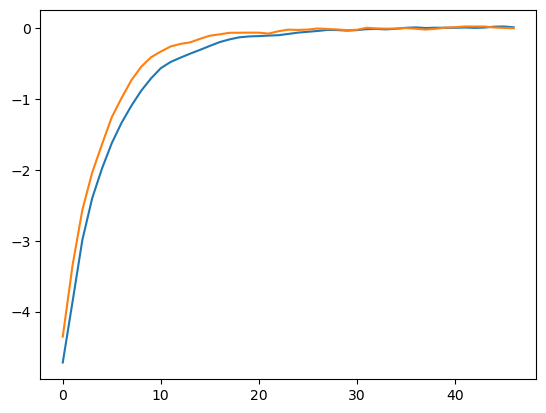

In [55]:
now = datetime.datetime.now()
print(now)

mode   = 10
EOF    = np.reshape(pca.components_[0:mode],[mode,dim[4]*dim[5]])
PC     = anomaly_all.dot(EOF.T).dot(np.linalg.inv(EOF.dot(EOF.T)))
EOF    = np.reshape(EOF,[mode,dim[4],dim[5]])
PC     = np.reshape(PC,[dim[0]*dim[1]*dim[2]*dim[3],mode])
PC_std = np.std(PC,axis=0)
PC     = PC/PC_std
EOF    = EOF.reshape([mode,dim[4]*dim[5]])*np.reshape(PC_std,[mode,1])
EOF    = EOF.reshape([mode,dim[4],dim[5]])

PC     = np.reshape(PC,[dim[0],dim[1],dim[2],dim[3],mode]) # 10 ensemble, 20 years, 12 months, 47 lead, 
series = np.mean(np.std(PC,axis=0)[:,:,:,0],axis=(0,1))
plt.plot(np.log(series/np.mean(series[30:])))
series = np.mean(np.std(PC,axis=0)[:,:,:,9],axis=(0,1))
plt.plot(np.log(series/np.mean(series[30:])))




## predictability component analysis

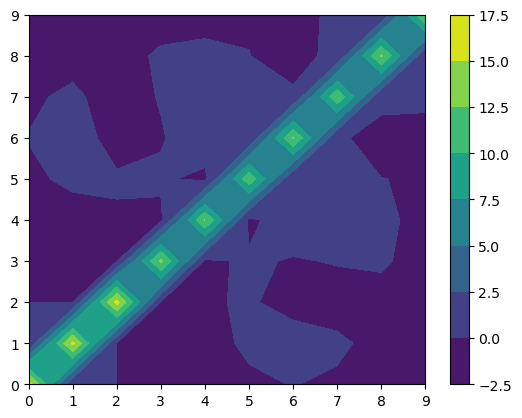

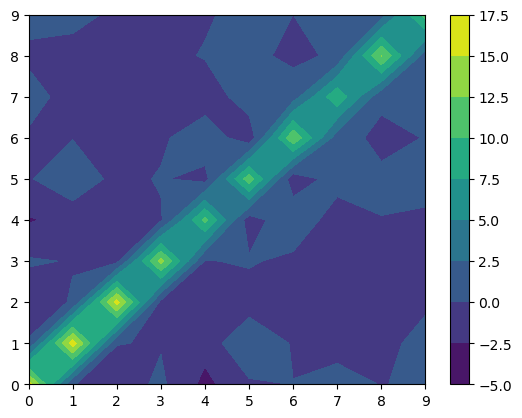

In [50]:
# PC has dimension of ens, year, month, lead, PC modes
# using lag 30-47 to define climatology 
# month            = [0,1,2,3,4,5,6,7,8,9,10,11]
month            = [0,1,10,11]
PC_winter        = PC[:,:,month,:,:]
dim_PC           = np.shape(PC[:,:,month,:,:])
sigma            = np.zeros((47,mode,mode))

for i in range(dim_PC[3]):
    count = 0
    for year_idx in range(dim_PC[1]):
        for month_idx in range(dim_PC[2]):
            tmp              = np.reshape(PC_winter[:,year_idx,month_idx,i,:]-np.mean(PC_winter[:,year_idx,month_idx,i,:], axis=0,keepdims=True),[dim_PC[0],mode])
            sigma[i,:,:]     = (tmp.T.dot(tmp)+sigma[i,:,:]*count)/(count+1)
            count            = count+1
sigma_inf = sigma[42:47,:,:].mean(axis=0)
plt.figure()
cs=plt.contourf(sigma[42:47,:,:].mean(axis=0))
plt.colorbar(cs)

cov_diff     = np.zeros((mode,mode))
for i in range(dim_PC[3]):
    cov_diff = ((sigma_inf-sigma[i,:,:]).dot(np.linalg.inv(sigma_inf))+cov_diff)
plt.figure()
cs=plt.contourf(cov_diff)
plt.colorbar(cs)

In [53]:
eigenvalues, eigenvectors = np.linalg.eig(cov_diff)
idx                       = eigenvalues.argsort()[::-1]   
eigenvalues               = eigenvalues[idx]
eigenvectors              = eigenvectors[:,idx] 


print(eigenvalues)
APTM1                     = np.reshape(eigenvectors[:,0],[mode,1])
APTM2                     = np.reshape(eigenvectors[:,1],[mode,1])
APTM3                     = np.reshape(eigenvectors[:,3],[mode,1])

[38.89190323 35.83038945 32.31558033 29.24275324 28.17077863 22.63495282
 20.8490681  19.60090891 17.72387799 12.83624333]


In [14]:
# print(APTM_time_series.shape)
# # APTM_clim = np.reshape(APTM_time_series[:,:,:,40:48,:],[10*20*4*7,mode])
# # APTM_T    = np.reshape(APTM_time_series,[10,20*4,47,mode])

print(np.shape(PC))

(10, 20, 12, 47, 10)


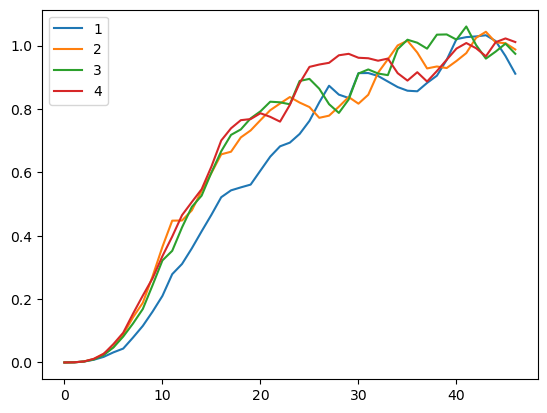

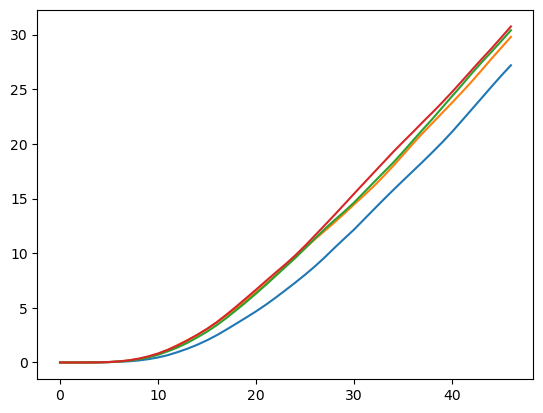

In [15]:
month                    = [0,1,10,11]
APTM_time_series         = np.reshape(PC[:,:,month,:,:],[dim_PC[0]*dim_PC[1]*dim_PC[2]*dim_PC[3],mode]).dot(eigenvectors)
APTM_time_series         = np.reshape(APTM_time_series,[dim_PC[0],dim_PC[1],dim_PC[2],dim_PC[3],mode])
APTM_clim                = np.reshape(APTM_time_series[:,:,:,40:48,:],[10*20*4,7,mode])
APTM_T                   = np.reshape(APTM_time_series,[10*20*4,47,mode])
#print(np.shape(APTM1_time_series))
plt.figure()
plt.plot((APTM_time_series[:,:,:,:,0].var(axis=0)).mean(axis=(0,1))/(APTM_time_series[:,:,:,40:47,0].var(axis=0)).mean(axis=(0,1,2)),label='1')
plt.plot((APTM_time_series[:,:,:,:,1].var(axis=0)).mean(axis=(0,1))/(APTM_time_series[:,:,:,40:47,1].var(axis=0)).mean(axis=(0,1,2)),label='2')
plt.plot((APTM_time_series[:,:,:,:,2].var(axis=0)).mean(axis=(0,1))/(APTM_time_series[:,:,:,40:47,2].var(axis=0)).mean(axis=(0,1,2)),label='3')
plt.plot((APTM_time_series[:,:,:,:,3].var(axis=0)).mean(axis=(0,1))/(APTM_time_series[:,:,:,40:47,3].var(axis=0)).mean(axis=(0,1,2)),label='4')

plt.legend()


# plot the accumulative variance 
tmp1 = (APTM_time_series[:,:,:,:,0].var(axis=0)).mean(axis=(0,1))/(APTM_time_series[:,:,:,40:48,0].var(axis=0)).mean(axis=(0,1,2))
tmp2 = (APTM_time_series[:,:,:,:,1].var(axis=0)).mean(axis=(0,1))/(APTM_time_series[:,:,:,40:48,1].var(axis=0)).mean(axis=(0,1,2))
tmp3 = (APTM_time_series[:,:,:,:,2].var(axis=0)).mean(axis=(0,1))/(APTM_time_series[:,:,:,40:48,2].var(axis=0)).mean(axis=(0,1,2))
tmp4 = (APTM_time_series[:,:,:,:,3].var(axis=0)).mean(axis=(0,1))/(APTM_time_series[:,:,:,40:48,3].var(axis=0)).mean(axis=(0,1,2))


tmp_accumu = np.zeros((47,4))
for i in range(47):
    tmp_accumu[i,0] = np.sum(tmp1[0:i])
    tmp_accumu[i,1] = np.sum(tmp2[0:i])
    tmp_accumu[i,2] = np.sum(tmp3[0:i])
    tmp_accumu[i,3] = np.sum(tmp4[0:i])
plt.figure()
plt.plot(tmp_accumu)
#plt.plot((APTM_time_series[:,:,:,:,1].std(axis=0)).mean(axis=(0,1)))
#plt.plot((APTM_time_series[:,:,:,:,2].std(axis=0)).mean(axis=(0,1)))
#plt.plot((APTM_time_series[:,:,:,:,3].std(axis=0)).mean(axis=(0,1)))

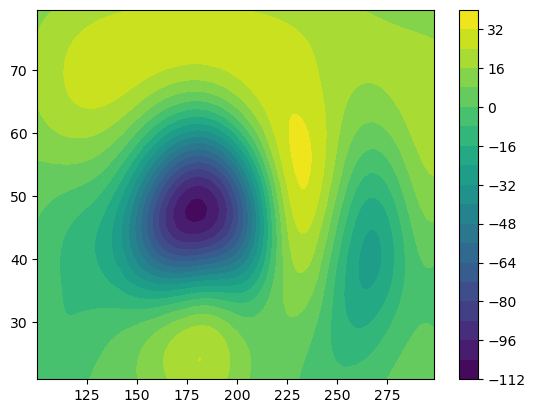

In [16]:

APTM_EOF = eigenvectors.T.dot(np.reshape(EOF,[mode,(lat_dim[-1]-lat_dim[0]+1)*(lon_dim[-1]-lon_dim[0]+1)]))
APTM_EOF = np.reshape(APTM_EOF,[mode,lat_dim[-1]-lat_dim[0]+1,lon_dim[-1]-lon_dim[0]+1])
plt.figure()
cs       = plt.contourf(lon[lat_dim[0]:lat_dim[-1]+1,lon_dim[0]:lon_dim[-1]+1],
                        lat[lat_dim[0]:lat_dim[-1]+1,lon_dim[0]:lon_dim[-1]+1],APTM_EOF[0,:],20)
plt.colorbar(cs)


## Building LE in a higher-dimension world



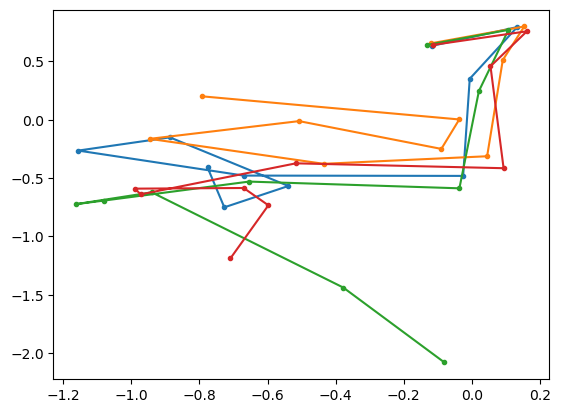

In [17]:
np.shape(APTM_time_series)
plt.figure()
plt.plot(APTM_time_series[0,1,1,0:10,0],APTM_time_series[0,1,1,0:10,1],'.-')
plt.plot(APTM_time_series[1,1,1,0:10,0],APTM_time_series[1,1,1,0:10,1],'.-')
plt.plot(APTM_time_series[2,1,1,0:10,0],APTM_time_series[2,1,1,0:10,1],'.-')
plt.plot(APTM_time_series[4,1,1,0:10,0],APTM_time_series[4,1,1,0:10,1],'.-')

# make probability density plot 
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter

# Step 1: 
# assign initial PDF to data point
x1_coordinate = APTM_time_series[:,1,1,0,0].mean(axis=0)
x2_coordinate = APTM_time_series[:,1,1,0,1].mean(axis=0)
x3_coordinate = APTM_time_series[:,1,1,0,2].mean(axis=0)
x4_coordinate = APTM_time_series[:,1,1,0,3].mean(axis=0)
#x5_coordinate = APTM_time_series[:,1,1,0,4].mean(axis=0)
diagonal_elements = [0.1, 0.1, 0.1, 0.1]
diagonal_matrix   = np.diag(diagonal_elements)
var               = multivariate_normal(mean=[x1_coordinate,x2_coordinate,x3_coordinate,x4_coordinate], cov=diagonal_elements)
ens_total         = 10
rho_ens           = np.zeros((ens_total,))

# assign initial probability density to the ten members. 

for ens in range(ens_total):
    rho_ens[ens]  = var.pdf([APTM_time_series[ens,1,1,0,0],APTM_time_series[ens,1,1,0,1],APTM_time_series[ens,1,1,0,2],APTM_time_series[ens,1,1,0,3]])
    

In [18]:
import numpy as np
from scipy.interpolate import griddata
rho_ens
ens              = 0
# choose the first five APT mode as the coordinate   
x_coordinate     = [x for x in APTM_time_series[0:10,1,1,0,0:5]]
print(griddata(x_coordinate,rho_ens,APTM_time_series[0:10,1,1,0,0:5].mean(axis=0),method='linear'))
print(rho_ens)
#rho_tmp         = griddata((rmm1_ML[t:-t_total+t],rmm2_ML[t:-t_total+t]),rho[:,t],(xi,zi),method='linear')

[2.52881328]
[2.52651762 2.52365802 2.52694815 2.52887215 2.53219715 2.53035656
 2.51132582 2.51617344 2.53133208 2.52912742]


-2.297820290497405


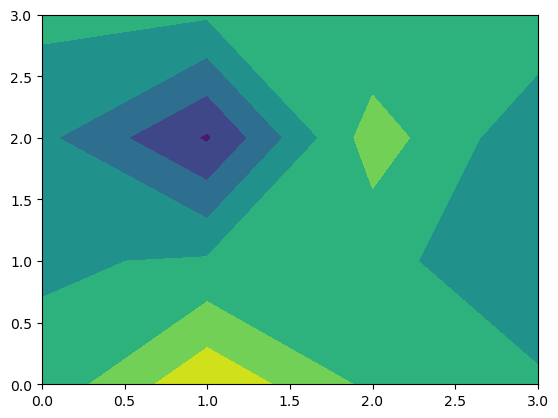

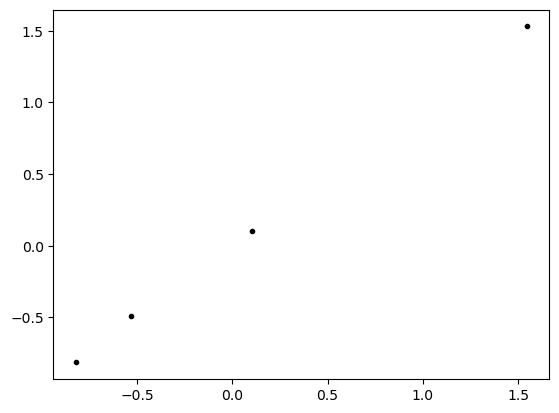

In [27]:
mode_for_training = 4

for year in range(17,18):
    for month in range(0,1):
        #x_t  = APTM_time_series[:,year,month,0,0:mode_for_training]\
        #       - np.reshape(APTM_time_series[:,year,month,0,0:mode_for_training].mean(axis=0),[1,mode_for_training]) # ens, states (variable)
        x_t  = APTM_time_series[:,year,month,0,0:mode_for_training]
        #x_t1 = APTM_time_series[:,year,month,1,0:mode_for_training]\
        #       - np.reshape(APTM_time_series[:,year,month,1,0:mode_for_training].mean(axis=0),[1,mode_for_training]) # ens, states (variable)
        x_t1 = APTM_time_series[:,year,month,1,0:mode_for_training]
        # x_t1 = x_t.dot(G)
        G    = np.linalg.inv(x_t.T.dot(x_t)).dot(x_t.T.dot(x_t1))
print(np.linalg.det(G))
plt.figure()
plt.contourf(G)
x_t1_template = x_t.dot(G)
plt.figure()
plt.plot(x_t1[3,:],x_t1_template[3,:],'k.')



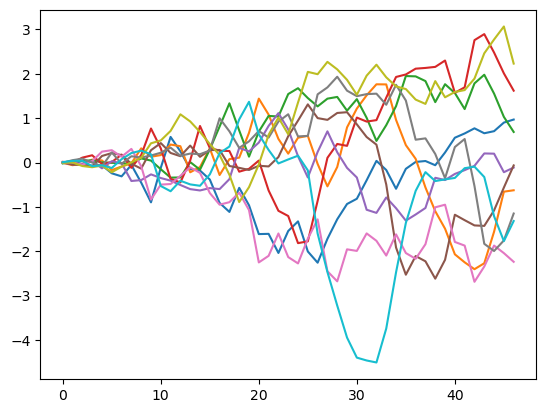

In [34]:
anomaly = APTM_time_series[:,year,month,:,:]- np.reshape(APTM_time_series[:,year,month,:,:].mean(axis=0),[1,47,10])
plt.figure()
plt.plot(anomaly[:,:,0].T)

## calculate the determinant 


In [35]:
lag                  = 3                    # choose the lag where the ensemble still behaves very linearly 
mode_for_training    = 4
G_record_as_time     = np.zeros((20,4,lag,mode_for_training,mode_for_training)) # year, month, 4X4 coefficient
det_record_as_time   = np.zeros((20,4,lag))

#mode_for_training    = 2
coordinate           = np.zeros((20,4,lag,mode_for_training))

for lag_idx in range(0,lag):
    for year in range(0,20):
        print('working on year='+str(year))
        for month in range(0,4):
            #x_t  = APTM_time_series[:,year,month,0,0:mode_for_training]\
            #       - np.reshape(APTM_time_series[:,year,month,0,0:mode_for_training].mean(axis=0),[1,mode_for_training]) # ens, states (variable)
            x_t  = APTM_time_series[:,year,month,lag_idx,0:mode_for_training]
            #x_t1 = APTM_time_series[:,year,month,1,0:mode_for_training]\
            #       - np.reshape(APTM_time_series[:,year,month,1,0:mode_for_training].mean(axis=0),[1,mode_for_training]) # ens, states (variable)
            x_t1 = APTM_time_series[:,year,month,lag_idx+1,0:mode_for_training]
            # x_t1 = x_t.dot(G)
            G_record_as_time[year-1,month-1,lag_idx,:,:]  = np.linalg.inv(x_t.T.dot(x_t)).dot(x_t.T.dot(x_t1))
            
            det_record_as_time[year-1,month-1,lag_idx]    = np.linalg.det(G_record_as_time[year-1,month-1,lag_idx,:,:])
            coordinate[year-1,month-1,lag_idx,:]          = APTM_time_series[:,year,month,0,0:mode_for_training].mean(axis=0)
            

working on year=0
working on year=1
working on year=2
working on year=3
working on year=4
working on year=5
working on year=6
working on year=7
working on year=8
working on year=9
working on year=10
working on year=11
working on year=12
working on year=13
working on year=14
working on year=15
working on year=16
working on year=17
working on year=18
working on year=19
working on year=0
working on year=1
working on year=2
working on year=3
working on year=4
working on year=5
working on year=6
working on year=7
working on year=8
working on year=9
working on year=10
working on year=11
working on year=12
working on year=13
working on year=14
working on year=15
working on year=16
working on year=17
working on year=18
working on year=19
working on year=0
working on year=1
working on year=2
working on year=3
working on year=4
working on year=5
working on year=6
working on year=7
working on year=8
working on year=9
working on year=10
working on year=11
working on year=12
working on year=13
work

In [244]:
%%ai chatgpt 
can you make a deep learning model with cross-validation in pytorch. Addting Ridge regularization to the deep learning model.

Sure, here is an example code snippet in PyTorch that demonstrates how to create a deep learning model with cross-validation and Ridge regularization:

```markdown
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold

# Define the deep learning model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(10, 100)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = MyModel()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)  # Adding Ridge regularization with weight_decay

# Perform cross-validation
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        print(f'Validation loss: {val_loss.item()}')
```

This code snippet demonstrates how to create a simple deep learning model, add Ridge regularization, and perform cross-validation using PyTorch.

## develop DNN for forecasting det

In [337]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

#lag = 3
# Define the deep learning model
class DeepLearningModel(nn.Module):
    def __init__(self):
        super(DeepLearningModel, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

x_tmp  = np.reshape(coordinate,[20*4*lag,4])
#y_tmp  = np.reshape(G_record_as_time,[20*4*lag,16])
y_tmp  = np.reshape(np.abs(det_record_as_time),[20*4*lag,1])
# choose the determinant with proper range for training 
#posi   = np.squeeze(np.where(np.abs(y_tmp)<5))[0]
#posi2  = np.squeeze(np.where(np.abs(y_tmp)>=5))[0]
x_tmp  = x_tmp[posi,:]
y_tmp  = y_tmp[posi]

X      = torch.from_numpy(x_tmp)
y      = torch.from_numpy(y_tmp)
X      = X.to(torch.float32)
y      = y.to(torch.float32)

# Define the LASSO regularization term
def lasso_reg(model, lambd):
    l1_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))
    return lambd * l1_reg

# Define hyperparameters
learning_rate = 0.05
num_epochs    = 20000
lambd         = 0


for weight_decay in [0.001,0.005,0.01,0.05]:
    print('weight_decay:'+str(weight_decay))
    for model_count in range(1):
        # Initialize the deep learning model
        model = DeepLearningModel()
        
        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
        
        # Perform k-fold cross-validation
        kf = KFold(n_splits=5)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Train the model
            for epoch in range(num_epochs):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train)
                loss    = criterion(outputs, y_train) + lasso_reg(model, lambd)
                loss.backward()
                optimizer.step()
            
            # Evaluate the model
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_loss = criterion(test_outputs, y_test)
    
            print(f'Test loss: {test_loss}')
    
    #torch.save(model.state_dict(), 'model_final_loss='+str(test_loss))
    
#plt.scatter(y,model(X).detach().numpy())


weight_decay:0.001
Test loss: 27.346195220947266
Test loss: 18.330753326416016
Test loss: 20.31404685974121
Test loss: 28.399723052978516
Test loss: 19.715194702148438
weight_decay:0.005
Test loss: 30.722152709960938
Test loss: 17.23097038269043
Test loss: 6.790789604187012
Test loss: 22.603227615356445
Test loss: 15.397313117980957
weight_decay:0.01
Test loss: 73.32244110107422
Test loss: 19.926477432250977
Test loss: 25.42073631286621
Test loss: 24.283716201782227
Test loss: 19.66644287109375
weight_decay:0.05
Test loss: 49.93684768676758
Test loss: 19.540889739990234
Test loss: 15.010202407836914
Test loss: 22.278676986694336
Test loss: 14.544018745422363


(0.0, 10.0)

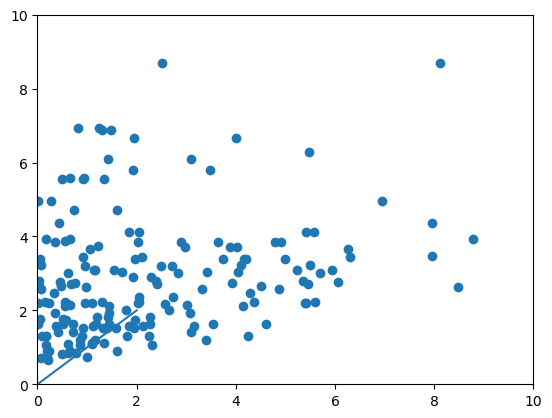

In [339]:
#model.load_state_dict(torch.load('model_final_loss=tensor(2.7370)'))
plt.figure()
plt.scatter(y,model(X).detach().numpy())
plt.plot(np.linspace(-2,2,100),np.linspace(-2,2,100))
plt.xlim([0,10])
plt.ylim([0,10])

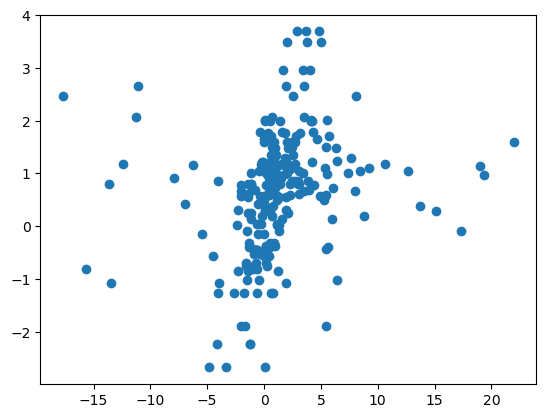

In [23]:
x_tmp = np.reshape(coordinate,[20*4*lag,4])
y_tmp = np.reshape(det_record_as_time,[20*4*lag,1])
#posi   = np.squeeze(np.where(np.abs(y_tmp)<5))[0]
#posi2  = np.squeeze(np.where(np.abs(y_tmp)>=5))[0]
#x_tmp = x_tmp[posi2,:]
#y_tmp = y_tmp[posi2]
X = torch.from_numpy(x_tmp)
y = torch.from_numpy(y_tmp)
X = X.to(torch.float32)
y = y.to(torch.float32)
plt.figure()
plt.scatter(y_tmp,model(X).detach().numpy())

## using griddata to find det over space

In [54]:
import numpy as np
from scipy.interpolate import griddata
# using fitting approach
x_tmp  = np.reshape(coordinate,[20*4*lag,mode_for_training])
y_tmp  = np.reshape(det_record_as_time,[20*4*lag,1])

#y_tmp  = np.reshape(G_record_as_time[:,:,:,0,0],[20*4*lag,1])

#print(np.shape(G_record_as_time))
#posi   = np.squeeze(np.where((np.abs(y_tmp)<3) & (np.abs(y_tmp)>0.5)))[0]
#posi2  = np.squeeze(np.where(np.abs(y_tmp)>=3))[0]
#x_tmp  = x_tmp[posi,:]
#y_tmp  = y_tmp[posi]



# Define the grid points for interpolation
grid_x, grid_y, grid_z, grid_t = np.mgrid[-4:4:20j, -4:4:20j,-4:4:20j,-4:4:20j]

# Perform interpolation
G_regrid = griddata(x_tmp, np.abs(y_tmp), (grid_x, grid_y,grid_z,grid_t), method='nearest', fill_value=1)
print(lag)

3


## using SVM (SVR) for estimating the determinant 

[[1.         0.31487324]
 [0.31487324 1.        ]]


<Figure size 640x480 with 0 Axes>

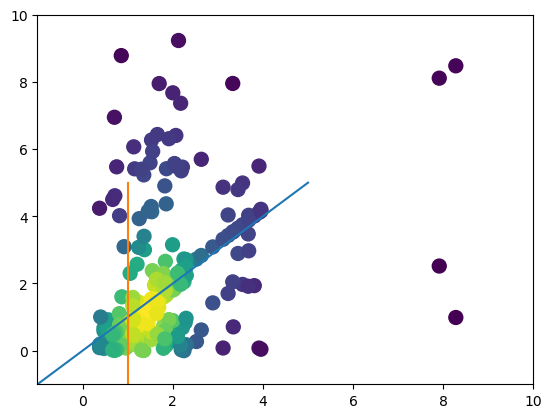

In [74]:

d = {}
from sklearn import svm
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
ens           = 50
for i in range(1, ens):
    X_train, X_test, y_train, y_test = train_test_split(x_tmp, np.abs(y_tmp).ravel(), test_size=0.2, random_state=i)
    # d["model{0}".format(i)] = svm.SVR(kernel="rbf", C=0.1, gamma=1, epsilon=0.2) 
    d["model{0}".format(i)] = svm.SVR(kernel="rbf", C=20, gamma=1, epsilon=0.2) # currently the best
    
    # C is the regularization parameters: 
    # big C-> complicated function (weak regularization) small C -> simple function (strong regularization)
    # bigger gamm = narrower spread
    d["model{0}".format(i)].fit(X_train, y_train)
    #X_train, X_test, y_train, y_test = train_test_split(x_tmp, y_tmp, test_size=0.3, random_state=)
    #model1.fit(X_train, y_train)
def multi_model(d,ens,x_tmp,y_true):
    y_tmp_predict = np.zeros((np.size(y_true),ens))
    count         = 0
    for i in range(1,ens):
        y_tmp_predict[:,i-1] = d["model{0}".format(i)].predict(x_tmp)
    return np.median(y_tmp_predict,axis=1)
    
    
plt.figure()
y_tmp_predict = np.reshape(multi_model(d,ens,x_tmp,y_tmp),np.shape(y_tmp))
xy = np.vstack([y_tmp_predict.T,np.abs(y_tmp).T])
z  = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
plt.scatter(y_tmp_predict.T, np.abs(y_tmp).T, c=z, s=100)
plt.plot(np.linspace(-1,5,100),np.linspace(-1,5,100))
plt.plot(np.linspace(-1,5,100)/np.linspace(-1,5,100),np.linspace(-1,5,100))

plt.xlim([-1,10])
plt.ylim([-1,10])
print(np.corrcoef(np.abs(y_tmp_predict).T,np.abs(y_tmp).T))



In [75]:
grid_x = np.reshape(grid_x,[20*20*20*20,1])
grid_y = np.reshape(grid_y,[20*20*20*20,1])
grid_z = np.reshape(grid_z,[20*20*20*20,1])
grid_t = np.reshape(grid_t,[20*20*20*20,1])
stacked_grid  = np.squeeze(np.stack((grid_x, grid_y,grid_z,grid_t), axis=1))
#ens           = 50
y_tmp_predict = np.zeros((np.size(grid_t),ens))
y_tmp_predict = multi_model(d,ens,stacked_grid,grid_t)
# for i in range(1,ens):
#     print(i)
#     y_tmp_predict[:,i-1] = d["model{0}".format(i)].predict(stacked_grid)

In [156]:
# print(np.shape(APTM_time_series)) # 10 ens, 20 year, 4 season, 47 day lead time, 10 APT mode

# # using all 10 members, first year, first month, all lead time and first 4 predictable 
# forecast_det = multi_model(d,ens,APTM_time_series[:,0,0,:,0:4].reshape([10*47,4]),APTM_time_series[:,0,0,:,0:1].reshape([10*47,1]))
# forecast_det = forecast_det.reshape([10,47])

(10, 20, 4, 47, 10)


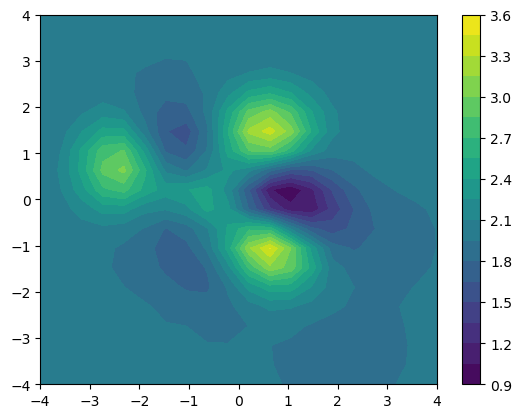

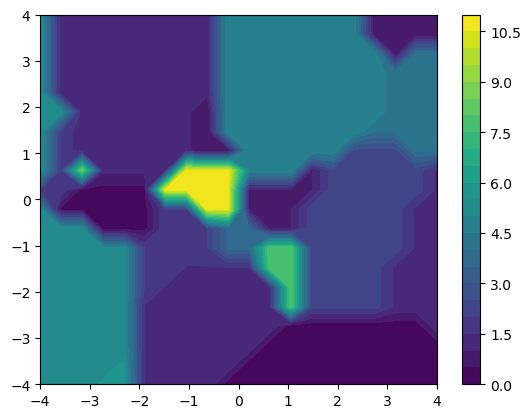

In [80]:
y_tmp_predict.max()
grid_x = np.reshape(grid_x,[20, 20, 20, 20])
grid_y = np.reshape(grid_y,[20, 20, 20, 20])
grid_z = np.reshape(grid_z,[20, 20, 20, 20])
grid_t = np.reshape(grid_t,[20, 20, 20, 20])
y_tmp_predict = np.reshape(y_tmp_predict,[20, 20, 20, 20])

plt.figure()
cs=plt.contourf(grid_z[10,10,:,:],grid_t[10,10,:,:],y_tmp_predict[12,12,:,:].squeeze(),20)
#plt.contour(grid_z[10,10,:,:],grid_t[10,10,:,:],G_regrid[6,6,:,:].squeeze(),20)
plt.colorbar(cs)

from scipy.ndimage import gaussian_filter
G_regrid = gaussian_filter(np.squeeze(G_regrid), sigma=(0.1,0.1,0.1,0.1))
plt.figure()
cs=plt.contourf(grid_z[10,10,:,:],grid_t[10,10,:,:],G_regrid[12,12,:,:].squeeze(),20)
plt.colorbar(cs)

In [210]:
# make probability density plot 
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter

# Step 1: 
# assign initial PDF to data point
x1_coordinate = APTM_time_series[:,1,1,0,0].mean(axis=0)
x2_coordinate = APTM_time_series[:,1,1,0,1].mean(axis=0)
x3_coordinate = APTM_time_series[:,1,1,0,2].mean(axis=0)
x4_coordinate = APTM_time_series[:,1,1,0,3].mean(axis=0)
#x5_coordinate = APTM_time_series[:,1,1,0,4].mean(axis=0)
mean = [x1_coordinate,x2_coordinate,x3_coordinate,x4_coordinate]

diagonal_elements = [0.001, 0.001, 0.001, 0.001]
diagonal_matrix   = np.diag(diagonal_elements)
var               = multivariate_normal(mean=[x1_coordinate,x2_coordinate,x3_coordinate,x4_coordinate], cov=diagonal_elements)
ens_total         = 10
rho_ens           = np.zeros((ens_total,))

# assign initial probability density to the ten members. 

for ens in range(ens_total):
    rho_ens[ens]  = var.pdf([APTM_time_series[ens,1,1,0,0],APTM_time_series[ens,1,1,0,1],APTM_time_series[ens,1,1,0,2],APTM_time_series[ens,1,1,0,3]])
    

In [48]:
## predicting tangent linear function using SVG
grid_x = np.reshape(grid_x,[20*20*20*20,1])
grid_y = np.reshape(grid_y,[20*20*20*20,1])
grid_z = np.reshape(grid_z,[20*20*20*20,1])
grid_t = np.reshape(grid_t,[20*20*20*20,1])
stacked_grid  = np.squeeze(np.stack((grid_x, grid_y,grid_z,grid_t), axis=1))
#ens           = 50
y_tmp_predict = np.zeros((np.size(grid_t),ens))
y_tmp_predict = multi_model(d,ens,stacked_grid,grid_t)

G_predict     = np.zeros((20**4,mode_for_training*mode_for_training))
# G_predict = np.zeros(np.shape(G_record_as_time))
# G_predict = np.reshape(G_predict,[20*4*lag,4*4])


for element in range(mode_for_training*mode_for_training):
    print('working on element:'+str(element))
    x_tmp     = np.reshape(coordinate,[20*4*lag,mode_for_training])
    y_tmp     = np.reshape(G_record_as_time.reshape([20*4*lag,4*4])[:,element],[20*4*lag,1])
    
    
    d         = {}
    from sklearn import svm
    from sklearn.model_selection import train_test_split
    from scipy.stats import gaussian_kde

    # using 30 different SVR
    ens           = 30
    for i in range(1, ens):
        X_train, X_test, y_train, y_test = train_test_split(x_tmp, y_tmp.ravel(), test_size=0.2, random_state=i)
        d["model{0}".format(i)] = svm.SVR(kernel="rbf", C=10, gamma=1, epsilon=0.2)
        d["model{0}".format(i)].fit(X_train, y_train)
        #X_train, X_test, y_train, y_test = train_test_split(x_tmp, y_tmp, test_size=0.3, random_state=)
        #model1.fit(X_train, y_train)
    def multi_model(d,ens,x_tmp,y_true):
        y_tmp_predict = np.zeros((np.size(y_true),ens))
        count         = 0
        for i in range(1,ens):
            y_tmp_predict[:,i-1] = d["model{0}".format(i)].predict(x_tmp)
        return np.median(y_tmp_predict,axis=1)
    
    G_predict[:,element] = multi_model(d,ens,stacked_grid,grid_t) #model, number of mudel, cordinate, shape of output


working on element:0
working on element:1
working on element:2
working on element:3
working on element:4
working on element:5
working on element:6
working on element:7
working on element:8
working on element:9
working on element:10
working on element:11
working on element:12
working on element:13
working on element:14
working on element:15


array([[ 1.        , -0.07816632],
       [-0.07816632,  1.        ]])

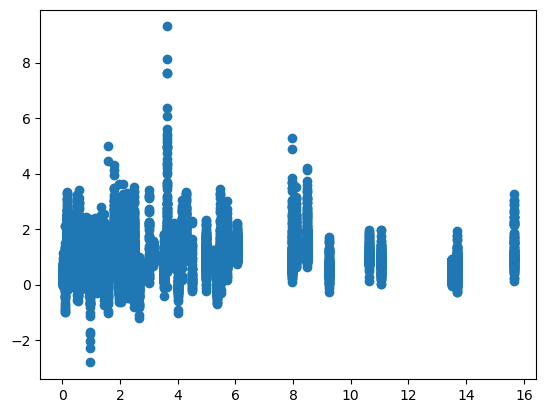

In [50]:
G_predict   = G_predict.reshape([np.size(grid_t),4,4])
det_predict = np.zeros((np.size(grid_t),1)) 
for i in range(G_predict.shape[0]):
    det_predict[i,0] = np.linalg.det(np.squeeze(G_predict[i,:,:]))

G1 = np.reshape(G_regrid,[20**4,1])
G2 = np.reshape(det_predict,[20**4,1])

plt.figure()
plt.scatter(G1,G2)
np.corrcoef(G1[0:100].T,np.abs(G2[0:100]).T)

In [234]:
# make a four-dimensional density
# grid_x = np.reshape(grid_x,[20*20*20*20,1])
# grid_y = np.reshape(grid_y,[20*20*20*20,1])
# grid_z = np.reshape(grid_z,[20*20*20*20,1])
# grid_t = np.reshape(grid_t,[20*20*20*20,1])


# find a better way to make initial PDF.
grid_rho = griddata((APTM_time_series[:,0,0,0,0],APTM_time_series[:,0,0,0,1],APTM_time_series[:,0,0,0,2],APTM_time_series[:,0,0,0,3]),
                    rho_ens,
                    (grid_x,grid_y,grid_z,grid_t),method='nearest', fill_value=1)

#grid_rho = gaussian_filter(np.squeeze(grid_rho), sigma=(1,1,1,1))
#print(grid_rho.max())
# grid_x = np.reshape(grid_x,[20, 20, 20, 20])
# grid_y = np.reshape(grid_y,[20, 20, 20, 20])
# grid_z = np.reshape(grid_z,[20, 20, 20, 20])
# grid_t = np.reshape(grid_t,[20, 20, 20, 20])
# grid_rho = np.reshape(grid_rho,[20, 20, 20, 20])
plt.figure()
cs=plt.contourf(grid_x[:,:,11,9],grid_y[:,:,11,9],grid_rho[:,:,10,10].squeeze(),20)
plt.colorbar(cs)

ValueError: Unknown interpolation method 'cubic' for 4 dimensional data

In [207]:
# make animation of predictable pattern analysis 

#APTM_time_series[:,1,1,0,0].mean(axis=0)
#np.reshape(APTM_time_series,[10*20*4*47,1])

#np.reshape(anomaly_all,[10*20*12*47,360,576])
f = open("/Users/kaichiht/Library/CloudStorage/GoogleDrive-kuiper2000@gmail.com/My Drive/Colab/2021_research/tornado_data/lat.bin", "r")
costal_lat         = np.fromfile(f, np.float32)
f = open("/Users/kaichiht/Library/CloudStorage/GoogleDrive-kuiper2000@gmail.com/My Drive/Colab/2021_research/tornado_data/lon.bin", "r")
costal_lon         = np.fromfile(f, np.float32)
grid   = plt.GridSpec(6, 6, wspace=0.15, hspace=1.5)
levels = np.linspace(-300, 300, 40)
lead   = 0

for lead in range(0,47):    
    fig=plt.figure()
    plt.subplot(grid[0:4, 0:3])
    tmp       = np.reshape(APTM_EOF,[10,(lat_dim[-1]-lat_dim[0]+1)*(lon_dim[-1]-lon_dim[0]+1)])
    
    cs        = plt.contourf(lon[lat_dim[0]:lat_dim[-1]+1,lon_dim[0]:lon_dim[-1]+1],
                            lat[lat_dim[0]:lat_dim[-1]+1,lon_dim[0]:lon_dim[-1]+1],
                            APTM_time_series[:,0,0,lead,:].mean(axis=0).dot(tmp).reshape([lat_dim[-1]-lat_dim[0]+1,lon_dim[-1]-lon_dim[0]+1]),
                            levels=levels,extend='both',
                            cmap='bwr')
    plt.plot(costal_lon,costal_lat,'gray')
    plt.colorbar(cs,boundaries=np.arange(-300,300,40), ticks=np.arange(-300,300,40))
    plt.xlim([120,300])
    plt.ylim([20,80])
    plt.xticks([120, 180,240,300],['$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$'], fontdict=None, minor=False,fontsize=18)
    plt.yticks([20,40,60,80],['$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'], fontdict=None, minor=False,fontsize=18)
    plt.title('(a) Combination of the first 10 predictable components',fontsize=18)
    
    plt.subplot(grid[0:4, 3:])
    cs       = plt.contourf(lon[lat_dim[0]:lat_dim[-1]+1,lon_dim[0]:lon_dim[-1]+1],
                            lat[lat_dim[0]:lat_dim[-1]+1,lon_dim[0]:lon_dim[-1]+1],
                            (anomaly_all.reshape([10,20,12,47,40,133]).mean(axis=0))[0,0,lead,:],
                            levels=levels,extend='both',
                            cmap='bwr')
    plt.plot(costal_lon,costal_lat,'gray')
    plt.colorbar(cs,boundaries=np.arange(-300,300,40), ticks=np.arange(-300,300,40))
    plt.xlim([120,300])
    plt.ylim([20,80])
    plt.xticks([120, 180,240,300],['$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$'], fontdict=None, minor=False,fontsize=18)
    plt.yticks([20,40,60,80],['$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'], fontdict=None, minor=False,fontsize=18)
    plt.title('(b) z300 anomaly',fontsize=18)
    
    
    plt.subplot(grid[4:, 0:2])
    plt.plot(APTM_time_series[:,0,0,0:47,0].T,color='gray')
    plt.scatter(np.arange(10)/np.arange(10)*lead,APTM_time_series[:,0,0,lead,0].T,color='k')
    plt.title('Predictable Component 1',fontsize=18)
    plt.xticks(np.arange(0,46,5),np.arange(0,46,5), fontdict=None, minor=False,fontsize=18)
    plt.xlabel('Lead Time',fontsize=15)
    
    plt.subplot(grid[4:, 2:4])
    plt.plot(APTM_time_series[:,0,0,0:47,1].T,color='gray')
    plt.scatter(np.arange(10)/np.arange(10)*lead,APTM_time_series[:,0,0,lead,1].T,color='k')
    plt.title('Predictable Component 2',fontsize=18)
    plt.xticks(np.arange(0,46,5),np.arange(0,46,5), fontdict=None, minor=False,fontsize=18)
    plt.xlabel('Lead Time',fontsize=15)
    
    plt.subplot(grid[4:, 4:6])
    plt.plot(APTM_time_series[:,0,0,0:47,5].T,color='gray')
    plt.scatter(np.arange(10)/np.arange(10)*lead,APTM_time_series[:,0,0,lead,5].T,color='k')
    plt.title('Predictable Component 3',fontsize=18)
    plt.xticks(np.arange(0,46,5),np.arange(0,46,5), fontdict=None, minor=False,fontsize=18)
    plt.xlabel('Lead Time',fontsize=15)
    fig.set_size_inches(24.5, 10.5)
    plt.savefig(str(lead).zfill(2)+".png")
    plt.close()

/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_32326/3313249565.py:50: RuntimeWarning: invalid value encountered in divide
  plt.scatter(np.arange(10)/np.arange(10)*lead,APTM_time_series[:,0,0,lead,0].T,color='k')
/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_32326/3313249565.py:57: RuntimeWarning: invalid value encountered in divide
  plt.scatter(np.arange(10)/np.arange(10)*lead,APTM_time_series[:,0,0,lead,1].T,color='k')
/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_32326/3313249565.py:64: RuntimeWarning: invalid value encountered in divide
  plt.scatter(np.arange(10)/np.arange(10)*lead,APTM_time_series[:,0,0,lead,5].T,color='k')
/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_32326/3313249565.py:50: RuntimeWarning: invalid value encountered in divide
  plt.scatter(np.arange(10)/np.arange(10)*lead,APTM_time_series[:,0,0,lead,0].T,color='k')
/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_32326/3313249565.py:57: RuntimeWarnin

In [208]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "*.png"
fp_out = "image.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [206]:
%%ai chatgpt
how to close open figure

To close an open figure in Python, use the `plt.close()` function from the matplotlib library. Here is an example code snippet:

```python
import matplotlib.pyplot as plt

# Plotting a figure
plt.plot([1, 2, 3, 4])
plt.show()

# Closing the open figure
plt.close()
```